In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read file

words = None
with open('names.txt') as f:
    words = f.read().splitlines()

print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Build vocabulary and encoder/decoder
chs = ['.'] + sorted(set("".join(word for word in words)))
print(chs)
stoi = {s:i for i, s in enumerate(chs)}
print(stoi)
itos = { v:k for k,v in stoi.items()}
print(itos)
stoi['e']

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


5

In [4]:
# Build dataset

# With context = 3:
# ... -> e
# ..e -> m
# .em -> m
# emm -> a
# mma -> .


def build_dataset(words, context_size=3):
    X = []
    Y = []

    for word in words:
        context = [0] * context_size
        chs = list(word) + ['.']
        for ch in chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(stoi[ch])
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

print(f'{Xtr.shape=} - {Ytr.shape=}')
print(f'{Xdev.shape=} - {Ydev.shape=}')
print(f'{Xtest.shape=} - {Ytest.shape=}')

print(f"{Xtr[1]=} - {Ytr[1]}")

Xtr.shape=torch.Size([182625, 3]) - Ytr.shape=torch.Size([182625])
Xdev.shape=torch.Size([22655, 3]) - Ydev.shape=torch.Size([22655])
Xtest.shape=torch.Size([22866, 3]) - Ytest.shape=torch.Size([22866])
Xtr[1]=tensor([ 0,  0, 25]) - 21


In [5]:
# Build neural network

EMB_SIZE = 10 # embedding size
VOCAB_SIZE = len(chs)
CONTEXT_SIZE = 3 
H1_SIZE = 200 # First hidden layer size
MINIBATCH_SIZE = 32

g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27,EMB_SIZE), generator=g)

# Initialize parameters W1, b1, W2, b2 (with generator) in a params list
W1 = torch.rand((EMB_SIZE * CONTEXT_SIZE, H1_SIZE), generator=g)
B1 = torch.rand(H1_SIZE, generator=g)
W2 = torch.rand((H1_SIZE,VOCAB_SIZE), generator=g)
B2 = torch.rand(VOCAB_SIZE, generator=g)

params = [C,W1,B1,W2,B2]

print(sum(p.nelement() for p in params))


11897


In [9]:
# Do forward and backward propagation

lri = []
lossi = []
stepi = []

for p in params:
    p.requires_grad = True


for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (MINIBATCH_SIZE,))

    # Forward
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, EMB_SIZE * CONTEXT_SIZE) @ W1 + B1) # -1 can be MINIBATCH_SIZE
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward
    for p in params:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

    print(str(loss.item()) + " - step: " + str(i))

7.281648635864258 - step: 0


In [18]:
print(f"{C.shape=}")
print(f"{ix.shape=}")
print(f"{emb.shape=}")
print(f"{emb.view(-1, EMB_SIZE * CONTEXT_SIZE).shape=}")

C.shape=torch.Size([27, 10])
ix.shape=torch.Size([32])
emb.shape=torch.Size([32, 3, 10])
emb.view(-1, EMB_SIZE * CONTEXT_SIZE).shape=torch.Size([32, 30])


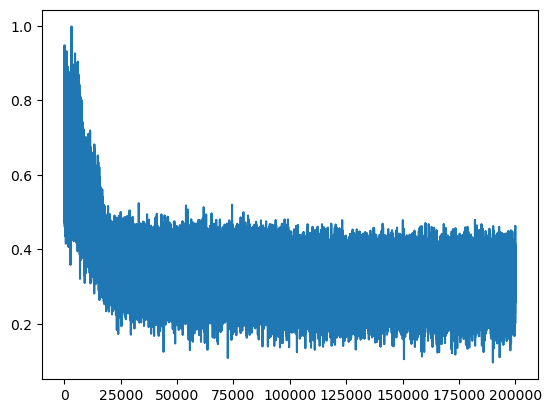

In [24]:
# Plot the loss and steps

plt.plot(stepi, lossi)



In [25]:
# Evaluate the training loss


emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # (32, 100)
logits = h @ W2 + B2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss



tensor(2.0616, grad_fn=<NllLossBackward0>)

In [28]:
# Evaluate the dev loss

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + B1) # (32, 100)
logits = h @ W2 + B2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss



tensor(2.1131, grad_fn=<NllLossBackward0>)

In [30]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * CONTEXT_SIZE # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + B1)
      logits = h @ W2 + B2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))



mora.
kayah.
see.
med.
rylla.
emmaniekdra.
grazeendielin.
shi.
jen.
eden.
edmanareelyzior.
kamin.
shubrrishirael.
kinde.
jenie.
novanni.
brence.
ryyah.
fael.
yuma.


In [38]:
C[torch.tensor([context])].shape


torch.Size([1, 3, 10])

# Notes

Batch size can be adjusted to converge faster and also reduce noise in loss